In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import datetime
import random
import os
import re
from collections import defaultdict

import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
#!pip freeze

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [119]:
sns.set(rc={'figure.figsize':(15,10)})

SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 17

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)  
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

### Importing data

In [5]:
def import_csv(filename, path = './data'):
    return pd.read_csv(os.path.join(path, filename))

In [6]:
test_activity = import_csv('act_test.csv')
train_activity = import_csv('act_train.csv')
people = import_csv('people.csv')

In [7]:
test_activity.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015


In [8]:
train_activity.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [9]:
people.head()

,people_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,False,True,True,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,type 2,type 4,False,False,True,True,False,False,False,True,False,False,False,False,False,True,False,True,True,True,False,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,type 2,type 2,True,True,True,True,True,True,False,True,False,True,False,True,True,True,True,True,True,True,True,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,type 2,type 2,True,True,True,True,True,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,type 2,type 2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,84


- Each row in the activity file represents a **unique activity** performed by a person on a certain date. Each activity has a unique activity_id.
- The activity file contains several different categories of activities. 
- **Type 1** activities are different from type 2-7 activities because there are more known chars associated with type 1 activities (**nine in total**) than type 2-7 activities (which have only one associated characteristic).
- The two files can be joined together using **person_id** as the common key. 
- All variables are categorical, with the exception of 'char_38' in the people file, which is a continuous numerical variable.

### Data cleaning

In [10]:
def _process_date(dataframe, date_col):
    """
    A private function which preprocesses datetime information.
    Input:
    - dataframe
    - name of the date column (object)
    
    Output:
    - dataframe with new date columns: month, year, weekend_flg
    """
    df = dataframe.copy()
    df['date'] = pd.to_datetime(df[date_col])
    df['month']=df['date'].dt.month
    df['year']=df['date'].dt.year
    df['weekend_flg'] = (df['date'].dt.weekday >= 5).astype(int)
    df.drop(['date'], inplace=True, axis=1)
    return df

In [11]:
def clean_people(original_df):
    """
    The aim of this function is to prepare `people` df by unifying types of data.
    The function takes in a dataframe (specifically `people`) and returns a copy of the given dataframe, but with converted data types (all ints).
    """
    df = _process_date(original_df, 'date')
    
    for col in list(df.select_dtypes(include='object').columns):
        if col.startswith("char_") or col.startswith("group_"):
            try:
                df[col] = (df[col].apply(lambda x: x.split(" ")[1]).astype("float64")).astype('int64')
                print(f"{col} converted to int")
            except AttributeError:
                print(f"Can't convert {col} to int")

        elif col.startswith("people_"):
            try:
                df[col] = (df[col].apply(lambda x: x.split("_")[1]).astype("float64")).astype('int64')
                print(f'{col} converted to int')
            except AttributeError:
                print(f"Can't convert {col} to int")
                
    for col in list(df.select_dtypes(include=['bool', 'float64']).columns):
        try:
            df[col] = df[col].astype("int64")
            print(f"{col} converted to int")
        except AttributeError:
            print(f"Can't convert {col} to int")
    return df

In [12]:
people_df = clean_people(people)

people_id converted to int
char_1 converted to int
group_1 converted to int
char_2 converted to int
char_3 converted to int
char_4 converted to int
char_5 converted to int
char_6 converted to int
char_7 converted to int
char_8 converted to int
char_9 converted to int
char_10 converted to int
char_11 converted to int
char_12 converted to int
char_13 converted to int
char_14 converted to int
char_15 converted to int
char_16 converted to int
char_17 converted to int
char_18 converted to int
char_19 converted to int
char_20 converted to int
char_21 converted to int
char_22 converted to int
char_23 converted to int
char_24 converted to int
char_25 converted to int
char_26 converted to int
char_27 converted to int
char_28 converted to int
char_29 converted to int
char_30 converted to int
char_31 converted to int
char_32 converted to int
char_33 converted to int
char_34 converted to int
char_35 converted to int
char_36 converted to int
char_37 converted to int


In [13]:
people_df.head()

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month,year,weekend_flg
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0
2,100003,2,33592,3,4,8,5,2,5,2,2,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,99,6,2022,0
3,100004,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,7,2022,0
4,100006,2,6534,3,40,25,9,3,8,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,84,7,2022,0


In [14]:
for data in [test_activity,train_activity]:
    print(data.isnull().sum())
    print("\n")

people_id                 0
activity_id               0
date                      0
activity_category         0
char_1               458595
char_2               458595
char_3               458595
char_4               458595
char_5               458595
char_6               458595
char_7               458595
char_8               458595
char_9               458595
char_10               40092
dtype: int64


people_id                  0
activity_id                0
date                       0
activity_category          0
char_1               2039676
char_2               2039676
char_3               2039676
char_4               2039676
char_5               2039676
char_6               2039676
char_7               2039676
char_8               2039676
char_9               2039676
char_10               157615
outcome                    0
dtype: int64




In [15]:
test_activity.head()

,people_id,activity_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015


In [16]:
#probably should extract this too with the rest of the activity id
train_activity['activity_id'].apply(lambda x: x.split("_")[0][-1]).unique()

array(['2', '1'], dtype=object)

In [17]:
def clean_activity(original_df):
    """
    The aim of this function is to prepare `activity` df (and test df) by unifying types of data.
    The function takes in a dataframe (specifically `activity`) and returns this dataframe, but with converted data types.
    """ 

    df = _process_date(original_df, 'date')
                               
    for col in list(df.select_dtypes(include='object').columns):
        if col.endswith("_id"):
            if col.startswith("activity"):
                try:
                    df[f"{col}_prefix"] = (df[col].apply(lambda x: x.split("_")[0][-1]).astype("float64")).astype("int64")
                    print(f"{col}_prefix created")
                except AttributeError:
                    print(f"Can't create {col}_prefix")
                try:
                    df[col] = (df[col].apply(lambda x: x.split("_")[1]).astype("float64")).astype("int64")
                    print(f"{col} converted to int")
                except AttributeError:
                    print(f"Can't convert {col} to int")              
            elif col.startswith("people"):
                try:
                    df[col] = (df[col].apply(lambda x: x.split("_")[1]).astype("float64")).astype("int64")
                    print(f"{col} converted to int")
                except AttributeError:
                    print(f"Can't convert {col} to int")
        else:
            df[col]= df[col].fillna('type -1')
            try:
                df[col] = (df[col].apply(lambda x: x.split(" ")[1]).astype("float64")).astype('int64')
                print(f"{col} converted to int")
            except AttributeError:
                print(f"Can't convert {col} to int")
                
    for col in list(df.select_dtypes(include=['bool', 'float64']).columns):
        try:
            df[col] = df[col].astype("int64")
            print(f"{col} converted to int")
        except AttributeError:
            print(f"Can't convert {col} to int")
    return df

In [18]:
test_activity_df= clean_activity(test_activity)

people_id converted to int
activity_id_prefix created
activity_id converted to int
activity_category converted to int
char_1 converted to int
char_2 converted to int
char_3 converted to int
char_4 converted to int
char_5 converted to int
char_6 converted to int
char_7 converted to int
char_8 converted to int
char_9 converted to int
char_10 converted to int


In [19]:
test_activity_df.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,month,year,weekend_flg,activity_id_prefix
0,100004,249281,1,5,10,5,1,6,1,1,7,4,-1,7,2022,0,1
1,100004,230855,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,682,7,2022,0,2
2,10001,240724,1,12,1,5,4,6,1,1,13,10,-1,10,2022,0,1
3,10001,83552,1,20,10,5,4,6,1,1,5,5,-1,11,2022,1,1
4,10001,1043301,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,3015,10,2022,1,2


In [20]:
train_activity_df= clean_activity(train_activity)

people_id converted to int
activity_id_prefix created
activity_id converted to int
activity_category converted to int
char_1 converted to int
char_2 converted to int
char_3 converted to int
char_4 converted to int
char_5 converted to int
char_6 converted to int
char_7 converted to int
char_8 converted to int
char_9 converted to int
char_10 converted to int


In [21]:
train_activity_df.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome,month,year,weekend_flg,activity_id_prefix
0,100,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1,2
1,100,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2
2,100,3404049,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2
3,100,3651215,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,0,2
4,100,4109017,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,1,2


In [22]:
def create_index(df, index=True):
    df['activity_index'] = df[['activity_id_prefix', 'activity_id']].apply(tuple, axis=1)
    if index:
        return df.set_index('activity_index')
    return df

In [23]:
test_activity_df = create_index(test_activity_df, False)
train_activity_df = create_index(train_activity_df, False)

In [24]:
test_activity_df.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,month,year,weekend_flg,activity_id_prefix,activity_index
0,100004,249281,1,5,10,5,1,6,1,1,7,4,-1,7,2022,0,1,"(1, 249281)"
1,100004,230855,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,682,7,2022,0,2,"(2, 230855)"
2,10001,240724,1,12,1,5,4,6,1,1,13,10,-1,10,2022,0,1,"(1, 240724)"
3,10001,83552,1,20,10,5,4,6,1,1,5,5,-1,11,2022,1,1,"(1, 83552)"
4,10001,1043301,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,3015,10,2022,1,2,"(2, 1043301)"


In [25]:
train_activity_df.head()

,people_id,activity_id,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome,month,year,weekend_flg,activity_id_prefix,activity_index
0,100,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1,2,"(2, 1734928)"
1,100,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 2434093)"
2,100,3404049,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 3404049)"
3,100,3651215,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,0,2,"(2, 3651215)"
4,100,4109017,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,1,2,"(2, 4109017)"


### Exploring `train_activity_df`

In [26]:
list(train_activity_df.columns)

['people_id',
 'activity_id',
 'activity_category',
 'char_1',
 'char_2',
 'char_3',
 'char_4',
 'char_5',
 'char_6',
 'char_7',
 'char_8',
 'char_9',
 'char_10',
 'outcome',
 'month',
 'year',
 'weekend_flg',
 'activity_id_prefix',
 'activity_index']

**Chars**

In [27]:
chars = list(train_activity_df.filter(regex= 'char_', axis=1).columns)

In [28]:
chars_acts_unique=defaultdict(int)

In [29]:
for char in chars:
    chars_acts_unique[char]= len((list(train_activity_df[char].unique())))

In [30]:
#type 10 stands out significantly
chars_acts_unique

defaultdict(int,
            {'char_1': 52,
             'char_2': 33,
             'char_3': 12,
             'char_4': 8,
             'char_5': 8,
             'char_6': 6,
             'char_7': 9,
             'char_8': 19,
             'char_9': 20,
             'char_10': 6516})

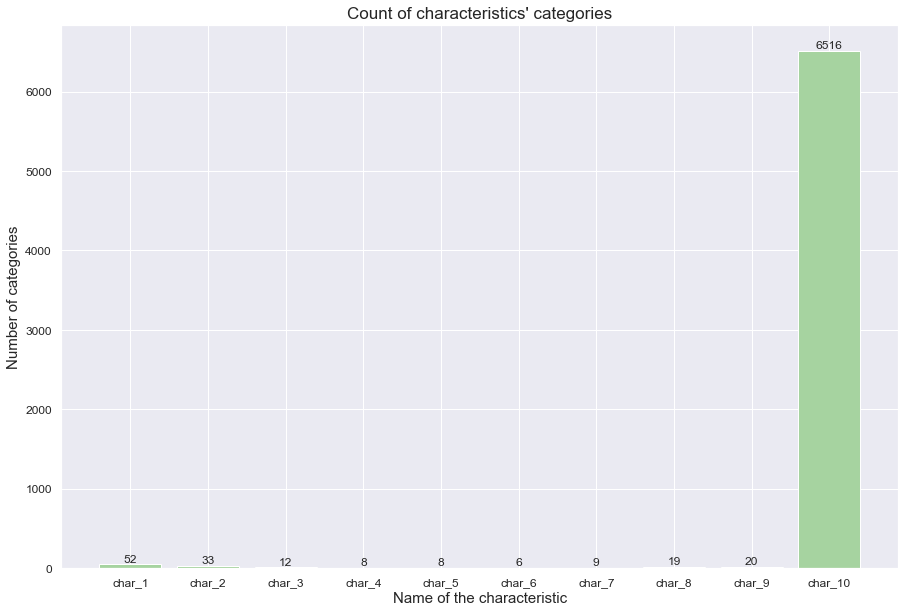

In [31]:
b = plt.bar(range(len(chars_acts_unique)), list(chars_acts_unique.values()), align='center', color = '#A6D3A0')
plt.xticks(range(len(chars_acts_unique)), list(chars_acts_unique.keys()))
plt.title("Count of characteristics' categories")
plt.xlabel('Name of the characteristic')
plt.ylabel('Number of categories')
for var in b:
    height = var.get_height()
    plt.text(var.get_x()+ var.get_width()/2.0, height, '%d' % int(height), ha = 'center', va = 'bottom')

`Char_10` differs significantly from the other characteristics - it contains more than 6000 categories

In [32]:
chars_acts_unique.pop('char_10')

6516

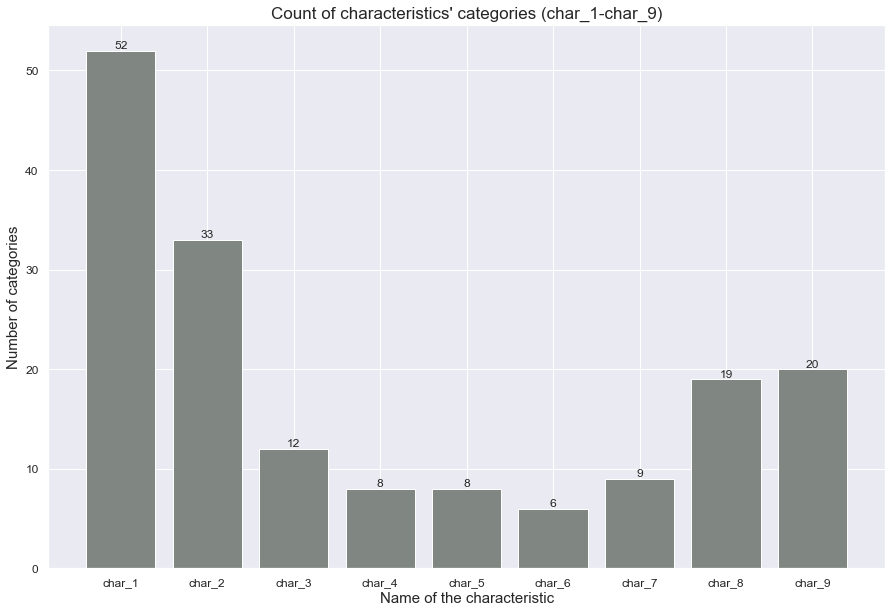

In [33]:
b = plt.bar(range(len(chars_acts_unique)), list(chars_acts_unique.values()), align='center', color = '#808782')
plt.xticks(range(len(chars_acts_unique)), list(chars_acts_unique.keys()))
plt.title("Count of characteristics' categories (char_1-char_9)")
plt.xlabel('Name of the characteristic')
plt.ylabel('Number of categories')
for var in b:
    height = var.get_height()
    plt.text(var.get_x()+ var.get_width()/2.0, height, '%d' % int(height), ha = 'center', va = 'bottom')

**`char_10`**

In [34]:
char10_stats = (pd.DataFrame(train_activity_df['char_10'].value_counts().sort_values(ascending=False)).reset_index()).rename(columns={'index':'type','char_10':'count'})

Text(0.5, 1.0, 'Distribution of values of char_10')

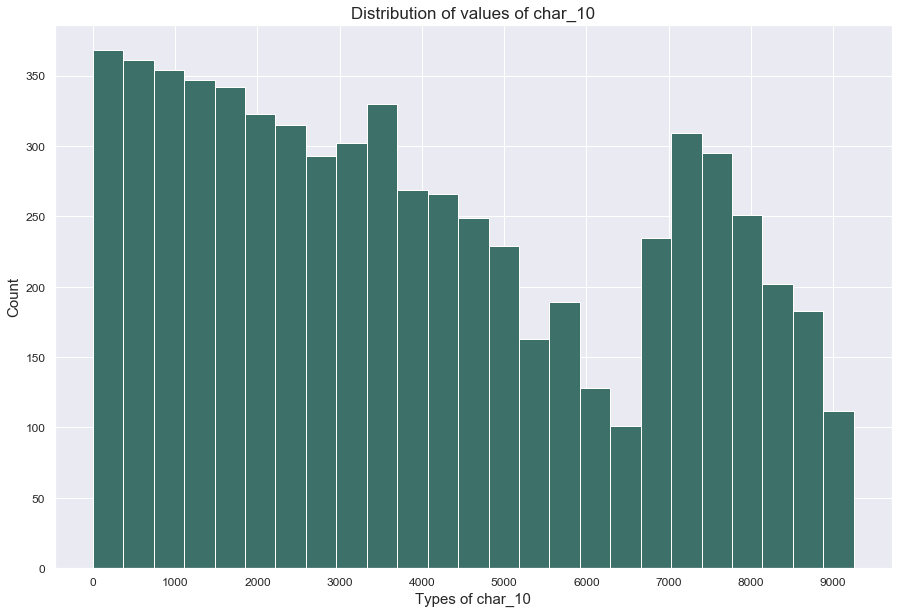

In [35]:
plt.hist(char10_stats['type'], bins=25, color = '#3D7068')
plt.xlabel('Types of char_10')
plt.ylabel('Count')
plt.xticks(ticks=list(range(0,9500,1000)))
plt.title('Distribution of values of char_10')

`char_10` has too many categories to encode and it will be dropped further on. 

**`char_1`-`char_9`**

In [36]:
cols = list(train_activity_df.columns)

In [37]:
chars_1_9 = [x for x in cols if x.startswith('char_') and int(x[-1]) in range(1,10)]

In [38]:
chars_1_to_9_df = train_activity_df[chars_1_9]

In [39]:
chars_1_to_9_df.head()

,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9
0,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [40]:
#base df with max number of types available for char_1-char_9
chars_agg = pd.DataFrame({'type': range(1, np.max(list(np.max(train_activity_df[chars_1_9])))+1)})

In [41]:
for x in chars_1_9:
    y = chars_1_to_9_df[x].value_counts().reset_index(drop=False).rename(columns={"index": "type"})
    chars_agg = pd.merge(chars_agg, y, how = 'left', on = 'type')

chars_agg.sort_values(by='type',ascending=True)

,type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9
0,1,14938.000,21616.000,38224.000,27979.000,49214.000,48658.000,52548.000,11621.000,24765.000
1,2,38030.000,50524.000,6577.000,9316.000,26982.000,61026.000,32199.000,4131.000,13488.000
2,3,12372.000,9810.000,19637.000,98131.000,6013.000,46124.000,42968.000,4909.000,5958.000
3,4,1329.000,781.000,20466.000,13730.000,1995.000,1241.000,8751.000,77460.000,8325.000
4,5,34509.000,31794.000,35488.000,5520.000,5421.000,566.000,8104.000,12396.000,11021.000
5,6,2385.000,5293.000,19631.000,2929.000,67989.000,nan,10604.000,10322.000,12824.000
6,7,7312.000,2311.000,9755.000,10.000,1.000,nan,1934.000,7737.000,6031.000
7,8,2110.000,5306.000,6473.000,nan,nan,nan,507.000,6657.000,31794.000
8,9,1225.000,2578.000,1328.000,nan,nan,nan,nan,6400.000,834.000
9,10,7795.000,6932.000,31.000,nan,nan,nan,nan,3897.000,6878.000


All chars contain types 1 to 5. `char_1` has the biggest number of types (from 1 to 52)

**Chars vs `activity_category`**

In [42]:
chars_acts = pd.DataFrame()

In [43]:
for char in chars:
    x = pd.DataFrame(train_activity_df['activity_category'][train_activity_df[char]!=-1].value_counts()).reset_index().rename(columns={'index':'type_of_activity','activity_category':'count'})
    x.set_index([[char]*len(x)], inplace=True)
    chars_acts = pd.concat([chars_acts,x], axis=0)

In [44]:
chars_acts[chars_acts['type_of_activity']!=1]

,type_of_activity,count
char_10,2,904683
char_10,5,490710
char_10,3,429408
char_10,4,207465
char_10,6,4253
char_10,7,3157


The activity file contains several different categories of activities. Type 1 activities are different from type 2-7 activities because there are more known characteristics associated with type 1 activities (nine in total) than type 2-7 activities (which have only one associated characteristic). - **char_10**

**`activity_category`**

In [45]:
acts = pd.DataFrame(train_activity_df.groupby(by='activity_category')['activity_id'].nunique().reset_index()).rename(columns={'activity_id':'count'})

In [46]:
acts

,activity_category,count
0,1,157615
1,2,904683
2,3,429408
3,4,207465
4,5,490710
5,6,4253
6,7,3157


Text(0.5, 1.0, 'The distribution of activities amongst activity categories')

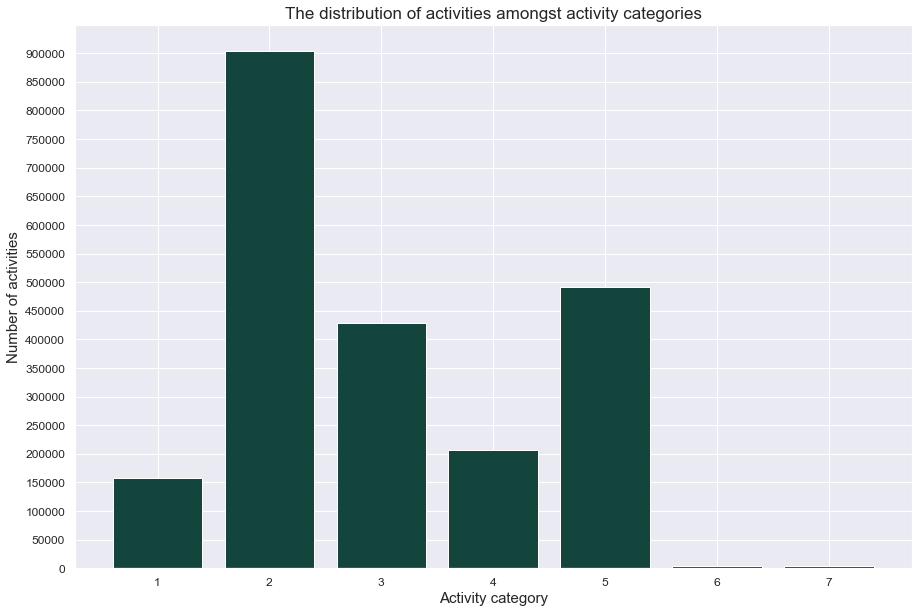

In [47]:
plt.bar(acts['activity_category'], acts['count'], color = '#14453D')
plt.yticks(list(range(0,905000,50000)))
plt.xlabel('Activity category')
plt.ylabel('Number of activities')
plt.title('The distribution of activities amongst activity categories')

Activity category type 2 is the most frequent one, while types 6 and 7 - the least frequent ones.

### Exploring `people_df`

In [48]:
list(people_df.columns)

['people_id',
 'char_1',
 'group_1',
 'char_2',
 'char_3',
 'char_4',
 'char_5',
 'char_6',
 'char_7',
 'char_8',
 'char_9',
 'char_10',
 'char_11',
 'char_12',
 'char_13',
 'char_14',
 'char_15',
 'char_16',
 'char_17',
 'char_18',
 'char_19',
 'char_20',
 'char_21',
 'char_22',
 'char_23',
 'char_24',
 'char_25',
 'char_26',
 'char_27',
 'char_28',
 'char_29',
 'char_30',
 'char_31',
 'char_32',
 'char_33',
 'char_34',
 'char_35',
 'char_36',
 'char_37',
 'char_38',
 'month',
 'year',
 'weekend_flg']

In [49]:
people_df.head()

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month,year,weekend_flg
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0
2,100003,2,33592,3,4,8,5,2,5,2,2,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,99,6,2022,0
3,100004,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,7,2022,0
4,100006,2,6534,3,40,25,9,3,8,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,84,7,2022,0


In [50]:
len(list(people_df['group_1'].unique()))

34224

**chars**

In [51]:
chars_people = list(people_df.filter(regex= 'char_', axis=1).columns)

In [52]:
chars_peps_unique=defaultdict(int)

In [53]:
for char in chars_people:
    chars_peps_unique[char]= len((list(people_df[char].unique())))

In [54]:
# char_10-char_37 only two categories - significantly different than in the activity df
chars_peps_unique

defaultdict(int,
            {'char_1': 2,
             'char_2': 3,
             'char_3': 43,
             'char_4': 25,
             'char_5': 9,
             'char_6': 7,
             'char_7': 25,
             'char_8': 8,
             'char_9': 9,
             'char_10': 2,
             'char_11': 2,
             'char_12': 2,
             'char_13': 2,
             'char_14': 2,
             'char_15': 2,
             'char_16': 2,
             'char_17': 2,
             'char_18': 2,
             'char_19': 2,
             'char_20': 2,
             'char_21': 2,
             'char_22': 2,
             'char_23': 2,
             'char_24': 2,
             'char_25': 2,
             'char_26': 2,
             'char_27': 2,
             'char_28': 2,
             'char_29': 2,
             'char_30': 2,
             'char_31': 2,
             'char_32': 2,
             'char_33': 2,
             'char_34': 2,
             'char_35': 2,
             'char_36': 2,
             'cha

It turns out that `people_df` contains much more characteristics with different numbers of categories. `char_1` and`char_10`-`char_37` only have two categories which makes them in fact booleans. The number of categories in other characteristics varies from 3 to 101.

Text(0, 0.5, 'Number of categories')

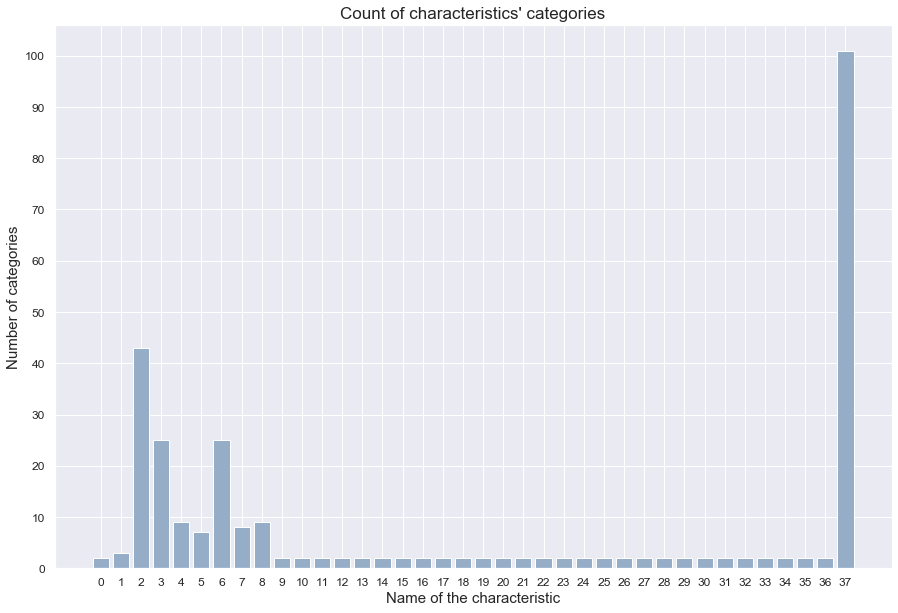

In [55]:
plt.bar(range(len(chars_peps_unique)), list(chars_peps_unique.values()), align='center', color = '#96ADC8')
plt.title("Count of characteristics' categories")
plt.xticks(ticks = list(range(0,38,1)))
plt.yticks(ticks = list(range(0,110,10)))
plt.xlabel('Name of the characteristic')
plt.ylabel('Number of categories')

**`group_1`**

`group_1` is a weird variable - no idea what it means

In [56]:
people_df.head(2)

,people_id,char_1,group_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month,year,weekend_flg
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0


In [57]:
pd.DataFrame(people_df['group_1'].value_counts().reset_index()).sort_values(by='group_1', ascending=False).head(2)

,index,group_1
0,17304,77314
1,667,1538


In [58]:
pd.DataFrame(people_df['group_1'].value_counts().reset_index()).sort_values(by='group_1', ascending=False).tail(2)

,index,group_1
20608,14230,1
34223,2049,1


**34224 different categories**, with the lowest count=1 and the highest count=77314

### Merging data 

In [59]:
# new pandas 1.0 feature - convert_dtypes(), to handle missing values
train_data = pd.merge(people_df, train_activity_df, how = 'left', on = 'people_id', suffixes = ('_pep', '_act')).convert_dtypes()
test_data = pd.merge(people_df, test_activity_df, how = 'left', on = 'people_id', suffixes = ('_pep', '_act')).convert_dtypes()

In [60]:
train_data.head()

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,month_act,year_act,weekend_flg_act,activity_id_prefix,activity_index
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1,2,"(2, 1734928)"
1,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 2434093)"
2,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,3404049,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 3404049)"
3,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,3651215,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,0,2,"(2, 3651215)"
4,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,4109017,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,1,2,"(2, 4109017)"


In [61]:
train_data.isnull().sum()[train_data.columns[train_data.isna().any()]]

activity_id           37823
activity_category     37823
char_1_act            37823
char_2_act            37823
char_3_act            37823
char_4_act            37823
char_5_act            37823
char_6_act            37823
char_7_act            37823
char_8_act            37823
char_9_act            37823
char_10_act           37823
outcome               37823
month_act             37823
year_act              37823
weekend_flg_act       37823
activity_id_prefix    37823
activity_index        37823
dtype: int64

In [62]:
test_data.head()

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,month_act,year_act,weekend_flg_act,activity_id_prefix,activity_index
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
1,100002,2,8688,3,28,9,5,3,11,2,4,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,1,1,1,1,1,1,1,0,76,1,2021,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
2,100003,2,33592,3,4,8,5,2,5,2,2,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,1,99,6,2022,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN
3,100004,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,7,2022,0,249281,1,5,10,5,1,6,1,1,7,4,-1,7,2022,0,1,"(1, 249281)"
4,100004,2,22593,3,40,25,9,4,16,2,2,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,76,7,2022,0,230855,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,682,7,2022,0,2,"(2, 230855)"


In [63]:
test_data.isnull().sum()[test_data.columns[test_data.isna().any()]]

activity_id           151295
activity_category     151295
char_1_act            151295
char_2_act            151295
char_3_act            151295
char_4_act            151295
char_5_act            151295
char_6_act            151295
char_7_act            151295
char_8_act            151295
char_9_act            151295
char_10_act           151295
month_act             151295
year_act              151295
weekend_flg_act       151295
activity_id_prefix    151295
activity_index        151295
dtype: int64

### Exploring `train_data`

In [64]:
train_data.head()

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,month_act,year_act,weekend_flg_act,activity_id_prefix,activity_index
0,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,1734928,4,-1,-1,-1,-1,-1,-1,-1,-1,-1,76,0,8,2023,1,2,"(2, 1734928)"
1,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,2434093,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 2434093)"
2,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,3404049,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 3404049)"
3,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,3651215,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,0,2,"(2, 3651215)"
4,100,2,17304,2,5,5,5,3,11,2,2,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,36,6,2021,0,4109017,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,8,2023,1,2,"(2, 4109017)"


In [65]:
#filling missing values with 'type -1' in `chars` as I did before in the cleaning section
for col in [col for col in list(train_data.columns) if (col.startswith('char_') and col.endswith('_act')) == True]:
    train_data[col]= train_data[col].fillna(-1)

In [66]:
#deleting records where outcome or activity_id are NaNs, because they are useless in case of modeling
train_data = train_data[(pd.isna(train_data['activity_id'])== False) & (pd.isna(train_data['outcome'])== False)]

In [67]:
train_data.columns

Index(['people_id', 'char_1_pep', 'group_1', 'char_2_pep', 'char_3_pep',
       'char_4_pep', 'char_5_pep', 'char_6_pep', 'char_7_pep', 'char_8_pep',
       'char_9_pep', 'char_10_pep', 'char_11', 'char_12', 'char_13', 'char_14',
       'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20',
       'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26',
       'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32',
       'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38',
       'month_pep', 'year_pep', 'weekend_flg_pep', 'activity_id',
       'activity_category', 'char_1_act', 'char_2_act', 'char_3_act',
       'char_4_act', 'char_5_act', 'char_6_act', 'char_7_act', 'char_8_act',
       'char_9_act', 'char_10_act', 'outcome', 'month_act', 'year_act',
       'weekend_flg_act', 'activity_id_prefix', 'activity_index'],
      dtype='object')

In [68]:
#duplicated variables - but with different values
# sorted(list(set((full.filter(regex= '_act', axis=1).columns))))

Doubled columns: `char_1`,`char_2`,`char_3`,`char_4`,`char_5`,`char_6`, `char_7`,`char_8`,`char_9`,`char_10` oraz `month`, `weekend_flg`, `year` 

All characteristics are categorical, except `char_38`

Each row represents an acitivity of a specific person (merged by `people_id`)

In [138]:
def plot_chars(dataset):
    """
    Input:
    - dataframe with characteristics (either train or test set)
    
    Output:
    -plots for each characterstic
    """
    
    cols_to_plot = list(dataset.filter(regex= 'char_', axis=1).columns)
    
    plt.figure(figsize=(20, 100))

    ax1=plt.subplot(2, 2, 1)

    for i, col in enumerate(cols_to_plot):
        plt.subplot(len(cols_to_plot)/2, 2, i+1, sharey=ax1)
        plt.subplots_adjust(hspace=0.5, wspace = 0.5)
        plt.hist(dataset[col], bins=50, color = '#28AFB0')
        plt.title(f"Distribution of categories for {col}")
        plt.xlabel("Category")
        plt.ylabel('Count')

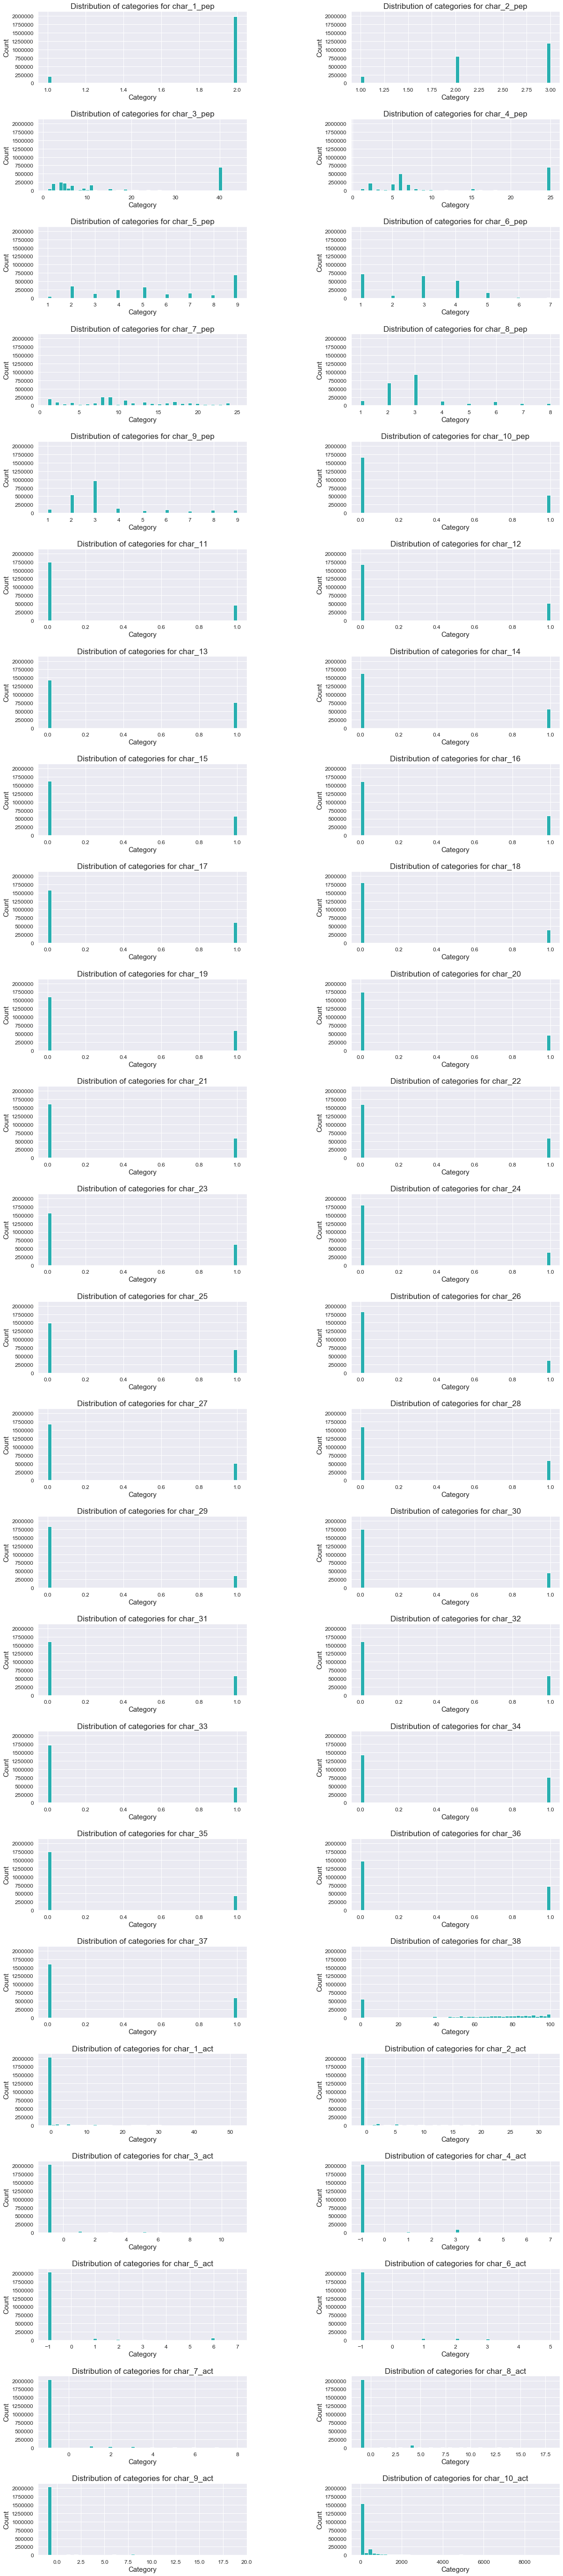

In [139]:
plot_chars(train_data)

### Looking on duplicates

In [71]:
train_data.shape

(2197291, 61)

In [72]:
train_data.drop_duplicates(inplace=True)

In [73]:
train_data.shape

(2197291, 61)

No full duplicates found

**Duplicates on `activity_id`**

In [74]:
activities_cnt = pd.DataFrame(train_data['activity_id'].value_counts().reset_index()).rename(columns={'index':'activity_id', 'activity_id':'act_cnt'})

In [75]:
activities_cnt[activities_cnt['act_cnt']>1].shape[0]

68174

In [76]:
acts_check = list(activities_cnt['activity_id'])

68174 duplicates on `activity_id`. Why?

In [77]:
#checking out the duplicates in the train_data df
train_data[train_data['activity_id'].isin(list(activities_cnt['activity_id'][activities_cnt['act_cnt']>1]))].sort_values(by='activity_id').head(15)

,people_id,char_1_pep,group_1,char_2_pep,char_3_pep,char_4_pep,char_5_pep,char_6_pep,char_7_pep,char_8_pep,char_9_pep,char_10_pep,char_11,char_12,char_13,char_14,char_15,char_16,char_17,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,char_28,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38,month_pep,year_pep,weekend_flg_pep,activity_id,activity_category,char_1_act,char_2_act,char_3_act,char_4_act,char_5_act,char_6_act,char_7_act,char_8_act,char_9_act,char_10_act,outcome,month_act,year_act,weekend_flg_act,activity_id_prefix,activity_index
1145072,291497,2,17304,2,19,2,5,3,8,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,1,2021,1,12,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,5,2023,0,2,"(2, 12)"
130805,114719,2,17304,2,5,6,3,3,8,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2021,0,12,1,5,2,8,3,5,3,3,9,18,-1,0,4,2023,0,1,"(1, 12)"
604323,198785,2,17304,2,2,6,2,4,13,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2023,0,16,1,12,1,6,3,2,2,3,4,6,-1,0,8,2023,0,1,"(1, 16)"
588977,19606,1,283,1,1,1,1,1,1,7,7,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,90,10,2021,1,16,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,10,2022,0,2,"(2, 16)"
612458,20012,2,17304,2,40,25,9,3,8,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,11,2022,0,21,1,5,2,3,3,5,2,2,4,3,-1,0,3,2023,1,1,"(1, 21)"
1377158,323025,2,17304,2,40,25,9,1,7,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2022,0,21,5,-1,-1,-1,-1,-1,-1,-1,-1,-1,4404,0,9,2022,0,2,"(2, 21)"
1399318,326933,2,6479,3,40,25,9,5,22,2,2,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,1,0,97,3,2022,0,36,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,0,9,2022,0,2,"(2, 36)"
698487,215407,2,46797,3,4,6,4,3,11,2,2,1,0,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,89,4,2023,1,36,1,1,6,1,1,1,1,1,3,1,-1,0,4,2023,1,1,"(1, 36)"
2128837,81439,2,7737,3,7,6,7,1,23,2,2,1,1,0,1,0,1,1,0,1,1,1,1,1,1,0,0,0,0,1,0,0,0,1,0,1,0,1,1,84,5,2022,0,37,1,5,2,2,3,1,3,3,4,17,-1,1,3,2023,0,1,"(1, 37)"
1738891,37595,2,3873,3,40,25,9,3,11,2,2,1,1,1,1,1,1,1,1,0,1,1,0,0,1,0,1,0,1,0,0,1,1,0,1,1,0,1,1,62,4,2021,1,37,2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,9,2022,1,2,"(2, 37)"


They are connected to different people, different characteristics, different activity categories and activity prefix.

**Duplicates on `activity_index`**

In [78]:
act_ind = pd.DataFrame(train_data['activity_index'].value_counts().reset_index()).rename(columns={'index':'activity_index','activity_index':'count'})

In [79]:
print(f"{act_ind[act_ind['count']>1].shape[0]} duplicates on activity_id with prefix")

0 duplicates on activity_id with prefix


The activity id combined with the prefix is a unique identificator and will be used as an index after data visualisation.

### Changes in activities over time

**Yearly**

In [80]:
yearly_pep = pd.DataFrame(train_data.groupby(by = ['year_pep', 'month_pep'])['activity_index'].count().reset_index()).rename(columns={'activity_index':'activities_pep'})

In [81]:
yearly_act = pd.DataFrame(train_data.groupby(by = ['year_act', 'month_act'])['activity_index'].count().reset_index()).rename(columns={'activity_index':'activities_act'})

In [82]:
yearly = pd.merge(yearly_pep, yearly_act, left_on = ['year_pep', 'month_pep'], right_on = ['year_act','month_act'], how = 'left').drop(columns=['year_act', 'month_act'], axis =1)

In [83]:
yearly

,year_pep,month_pep,activities_pep,activities_act
0,2020,5,16668,nan
1,2020,6,27013,nan
2,2020,7,20372,nan
3,2020,8,18848,nan
4,2020,9,14927,nan
5,2020,10,47001,nan
6,2020,11,29436,nan
7,2020,12,25002,nan
8,2021,1,24104,nan
9,2021,2,71532,nan


The dates are probably encoded as they contain future dates.

There are no activities tracked in the activity df before July 2022.

In [84]:
yearly['date'] = yearly.apply(lambda x: datetime.datetime.strptime(str(int(x['year_pep'])) + "," + str(int(x['month_pep'])) + ",1", '%Y,%m,%d' ), axis=1)

Text(0.5, 1.0, 'Number of activities over time')

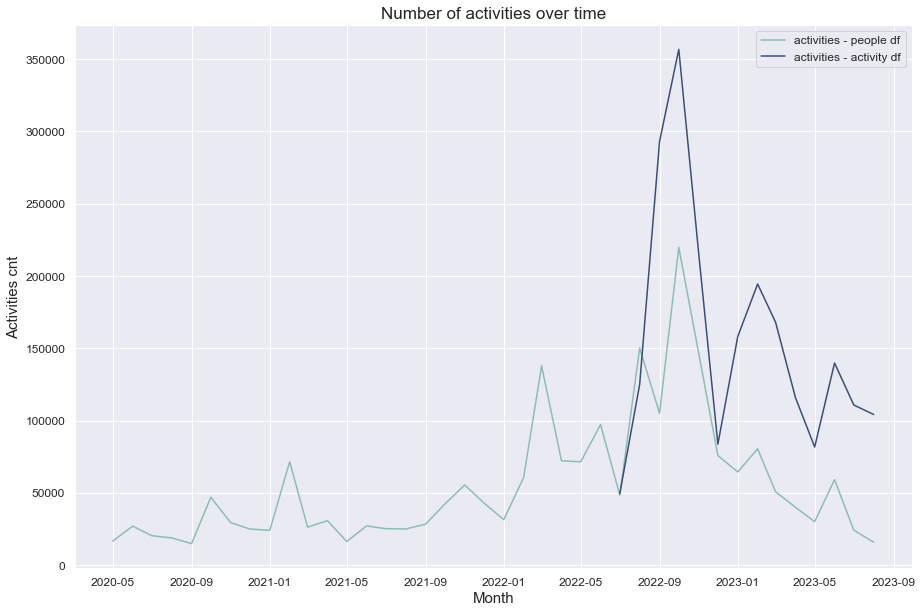

In [85]:
p1, = plt.plot(yearly['date'], yearly['activities_pep'], color = '#8BBEB2')
p2, = plt.plot(yearly['date'], yearly['activities_act'], color = '#384E77')
# plt.xticks(ticks = list(range(1,13)), labels = ['Jan', 'Feb','Mar', 'Apr','May','Jun','Jul','Aug','Sept', 'Oct','Nov', 'Dec'])
plt.legend([p1, p2], ["activities - people df", "activities - activity df"])
plt.xlabel("Month")
plt.ylabel("Activities cnt")
plt.title("Number of activities over time")

We can observe a **significant increase** in the number of activities (people df) in **October/November and February** each year since 2020. There are also slight **increases in June**. The number of activities was increasing till the late 2022 and then it started to diminish.

In case of activities in the activity df three peaks are noticable - in October, February and June 2023. Those peaks correspond to peaks of activities from the people df. However, the number of activities in the activity df is significantly higher in this period.

**Monthly**

In [86]:
dates_act = pd.DataFrame(train_data.groupby(by=["year_act", "month_act"])['activity_index'].count().reset_index())
months_act = pd.DataFrame(dates_act['month_act'].value_counts().reset_index()).rename(columns={'index':'month_act', 'month_act':'num_of_occurences_ACT'})
month_act_acts = pd.DataFrame(train_data[['month_act','activity_index']].groupby(by = 'month_act')['activity_index'].count().reset_index()).rename(columns={'activity_index':'act_cnt_ACT'})

In [87]:
months = pd.merge(months_act, month_act_acts, on = 'month_act')

In [88]:
months['avg_acts_ACT'] = months['act_cnt_ACT']/ months['num_of_occurences_ACT']

In [89]:
dates_pep = pd.DataFrame(train_data.groupby(by=["year_act", "month_pep"])['activity_index'].count().reset_index())
months_pep = pd.DataFrame(dates_pep['month_pep'].value_counts().reset_index()).rename(columns={'index':'month_pep', 'month_pep':'num_of_occurences_PEP'})
month_pep_acts = pd.DataFrame(train_data[['month_pep','activity_index']].groupby(by = 'month_pep')['activity_index'].count().reset_index()).rename(columns={'activity_index':'act_cnt_PEP'})

In [90]:
months_p = pd.merge(months_pep, month_pep_acts, on = 'month_pep')

In [91]:
months_p['avg_acts_PEP'] = months_p['act_cnt_PEP']/ months_p['num_of_occurences_PEP']

In [92]:
months = pd.merge(months, months_p, left_on = 'month_act', right_on = 'month_pep')

In [93]:
months = months[['month_act', 'act_cnt_ACT', 'avg_acts_ACT', 'act_cnt_PEP', 'avg_acts_PEP']]

In [94]:
months = months.sort_values(by = 'month_act').reset_index(drop=True)

In [95]:
del dates_act
del months_act
del month_act_acts

del dates_pep
del months_pep
del month_pep_acts
del months_p

Text(0.5, 1.0, 'Average number of activities in each month')

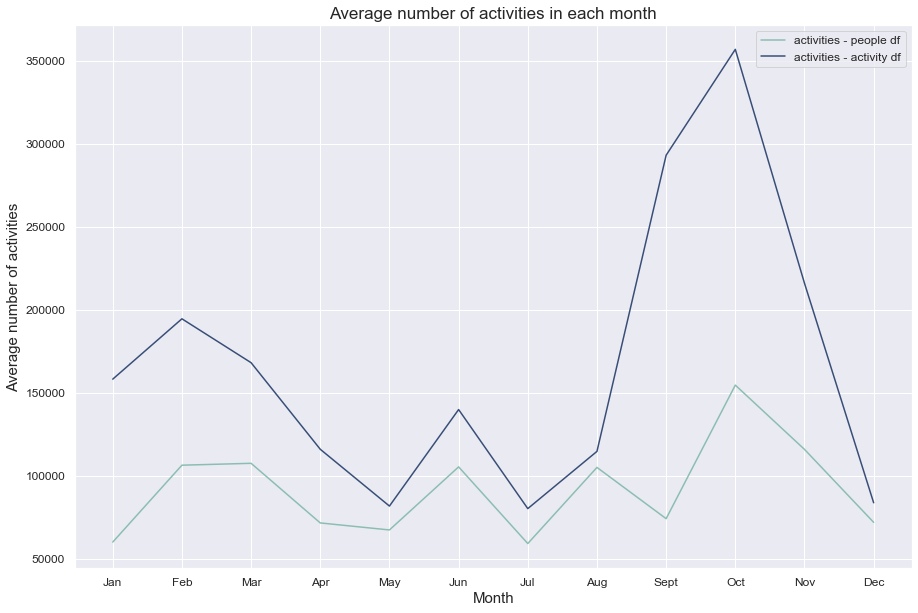

In [96]:
p1, = plt.plot(months['month_act'], months['avg_acts_PEP'],color = '#8BBEB2')
p2, = plt.plot(months['month_act'], months['avg_acts_ACT'], color = '#384E77')
plt.xticks(ticks = list(range(1,13)), labels = ['Jan', 'Feb','Mar', 'Apr','May','Jun','Jul','Aug','Sept', 'Oct','Nov', 'Dec'])
plt.legend([p1, p2], ["activities - people df", "activities - activity df"])
plt.xlabel("Month")
plt.ylabel("Average number of activities")
plt.title("Average number of activities in each month")

We see that the trend is similar for both dataframes, with the biggest **difference in September**. The plot also proves the **peaks in June, October and February**.

But how does the coverage of activities look like between those two sources of activities?

In [97]:
#the same as above, but a stacked plot with the intersection, pep and act unique
inter_act = {}

In [98]:
for x in range(1,13):
    inter_act[x] = list(train_data['activity_index'][(train_data['month_act']==x) & (train_data['month_pep']==x) ].unique())

In [99]:
months['intersection_activities'] = [len(inter_act[x]) for x in range(1,13)]

In [100]:
months['unique_act'] = months['act_cnt_ACT'] - months['intersection_activities'] 
months['unique_pep'] = months['avg_acts_PEP'] - months['intersection_activities'] 

Text(0.5, 1.0, 'Number of activities in each month in the context of the source of activity')

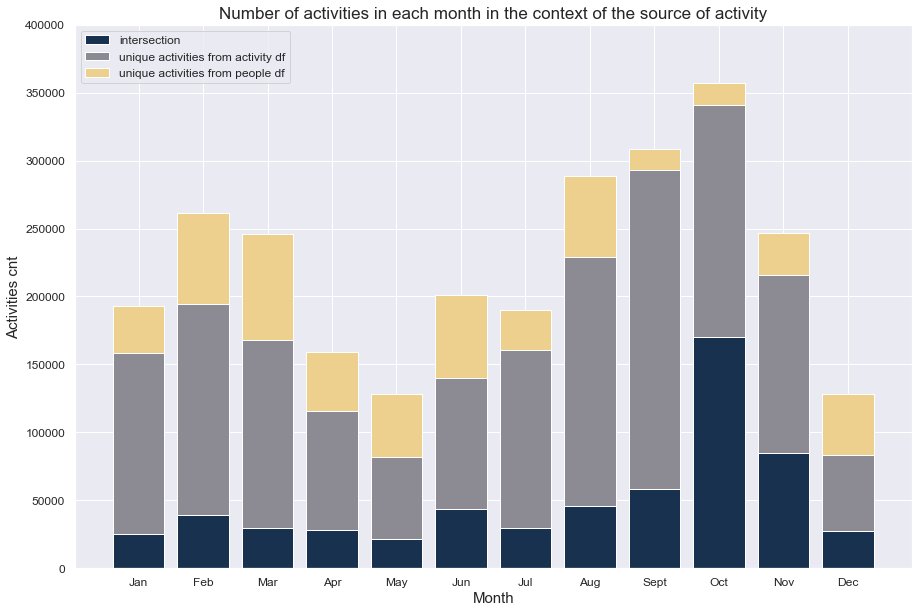

In [101]:
bottom = np.array(months['intersection_activities'] + months['unique_act'])

b1 = plt.bar(months['month_act'], months['intersection_activities'], color = '#18314F')
b2 = plt.bar(months['month_act'], months['unique_act'], color = '#8C8A93', bottom = months['intersection_activities'])
b3 = plt.bar(months['month_act'], months['unique_pep'], color = '#EDCF8E', bottom = bottom)
plt.xticks(ticks = list(range(1,13)), labels = ['Jan', 'Feb','Mar', 'Apr','May','Jun','Jul','Aug','Sept', 'Oct','Nov', 'Dec'])
plt.yticks(ticks = list(range(0,400001,50000)))
plt.legend([b1, b2, b3], ["intersection", "unique activities from activity df", "unique activities from people df"])
plt.xlabel("Month")
plt.ylabel("Activities cnt")
plt.title("Number of activities in each month in the context of the source of activity")

The intersection between two groups of activities is rather small, excluding October activities.

**Weekend vs. weekday**

In [102]:
week_act = pd.DataFrame(train_data.groupby(by = 'weekend_flg_act')['activity_index'].count().reset_index()).rename(columns={'activity_index':'acts_act'})
week_pep = pd.DataFrame(train_data.groupby(by = 'weekend_flg_pep')['activity_index'].count().reset_index()).rename(columns={'activity_index':'acts_pep'})

In [104]:
week = pd.merge(week_act, week_pep, left_on = 'weekend_flg_act', right_on = 'weekend_flg_pep').drop('weekend_flg_pep', axis=1)

Text(0.5, 1.0, 'Number of activities depending on the part of the week')

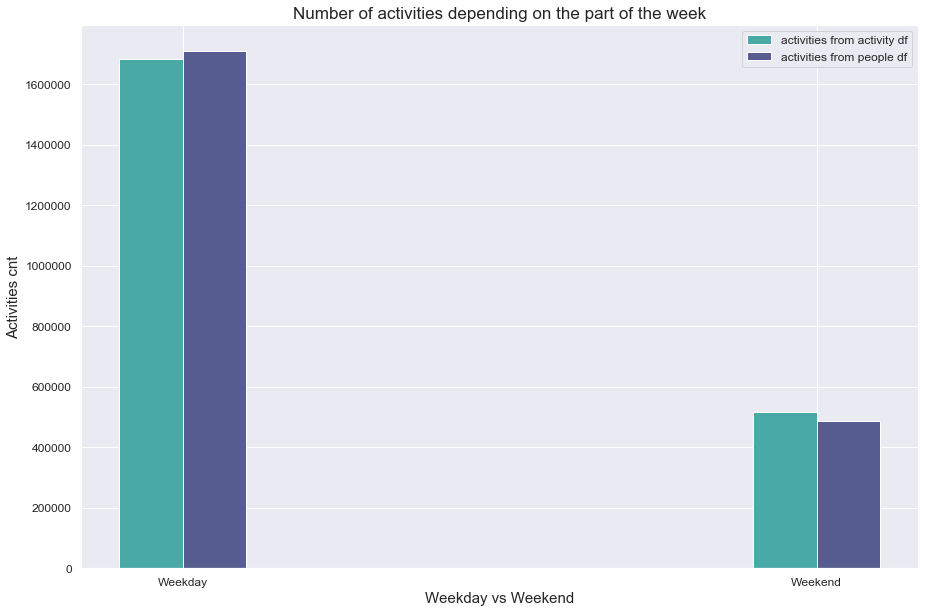

In [105]:
b1 = plt.bar(week['weekend_flg_act']-0.1, week['acts_act'], width=0.1, color='#48A9A6', align='edge')
b2 = plt.bar(week['weekend_flg_act']+0.05, week['acts_pep'], width=0.1, color='#575D90', align='center')
plt.xticks(ticks = list(range(0,2)), labels = ['Weekday','Weekend'])
plt.legend([b1, b2], ["activities from activity df","activities from people df"])
plt.xlabel("Weekday vs Weekend")
plt.ylabel("Activities cnt")
plt.title("Number of activities depending on the part of the week")

The majority of activities (from both dataframes) happen **on weekdays**.

**Outcomes depending on the weekend**

In [156]:
week_act = pd.DataFrame(train_data.groupby(by = ['weekend_flg_act', 'outcome'])['activity_index'].count().reset_index()).rename(columns={'activity_index':'acts_act'})

In [157]:
week_pep = pd.DataFrame(train_data.groupby(by = ['weekend_flg_pep', 'outcome'])['activity_index'].count().reset_index()).rename(columns={'activity_index':'acts_pep'})

In [158]:
week_pep

,weekend_flg_pep,outcome,acts_pep
0,0,0,923369
1,0,1,787432
2,1,0,298425
3,1,1,188065


In [166]:
# b1 = plt.bar(week_pep['weekend_flg_pep'][week_pep['outcome']==0]-0.1, week_pep['acts_pep'][week_pep['outcome']==0], width=0.1, color='#36558F', align='edge')
# b1 = plt.bar(week_pep['weekend_flg_pep'][week_pep['outcome']==1]+0.1, week_pep['acts_pep'][week_pep['outcome']==1], width=0.1, color='#8BBEB2', align='center')
# plt.xticks(ticks = list(range(0,2)), labels = ['Weekday','Weekend'])
# plt.xlabel("Weekday vs Weekend")
# plt.ylabel("Activities cnt")
# plt.title("Number of activities depending on the part of the week")

#### Outcome

In [132]:
outcomes = pd.DataFrame(train_data.groupby(by = ['outcome'])['activity_index'].count().reset_index())

In [133]:
outcomes

,outcome,activity_index
0,0,1221794
1,1,975497


Text(0.5, 1.0, 'Number of activities with each outcome')

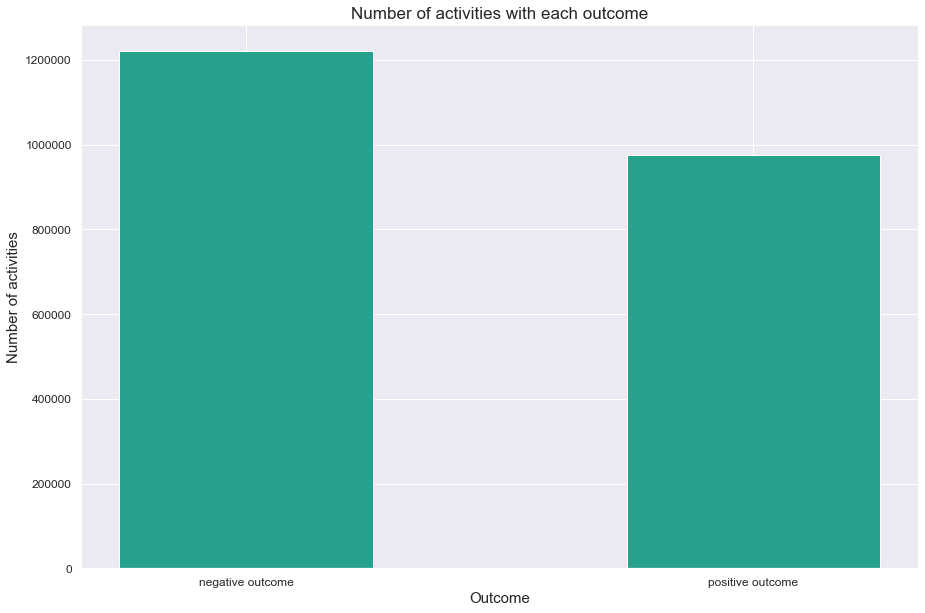

In [137]:
plt.bar(outcomes['outcome'], outcomes['activity_index'], color = '#25A18E', width = 0.5)
plt.xlabel('Outcome')
plt.ylabel('Number of activities')
plt.xticks(ticks = [0,1], labels = ['negative outcome', 'positive outcome'])
plt.title('Number of activities with each outcome')

#### People and activities

In [116]:
peps_acts = pd.DataFrame(train_data.groupby(by = 'people_id')['activity_index'].count().reset_index())

Text(0.5, 1.0, 'Number of activities per person')

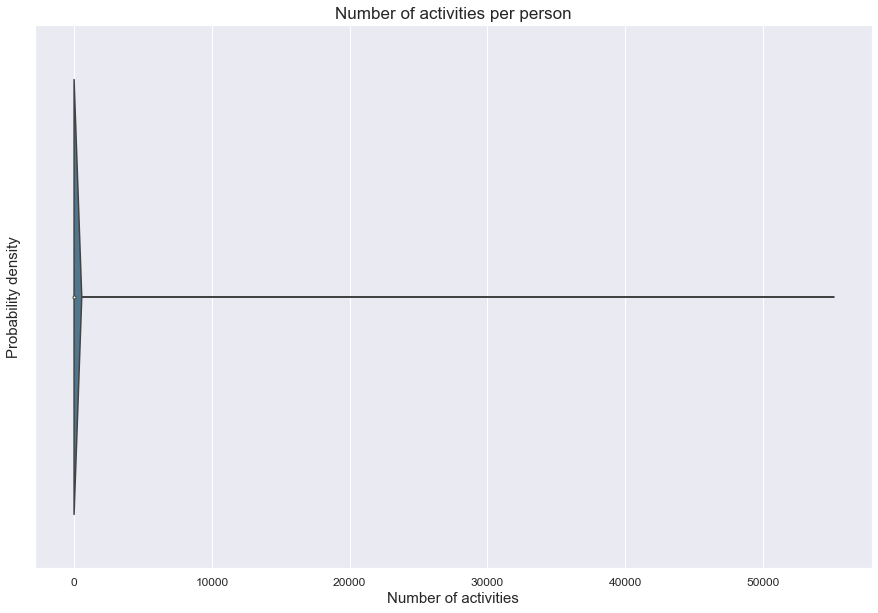

In [123]:
sns.violinplot(peps_acts['activity_index'], color = '#477998')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.title('Number of activities per person')

Text(0.5, 1.0, 'Number of activities per person - max 100')

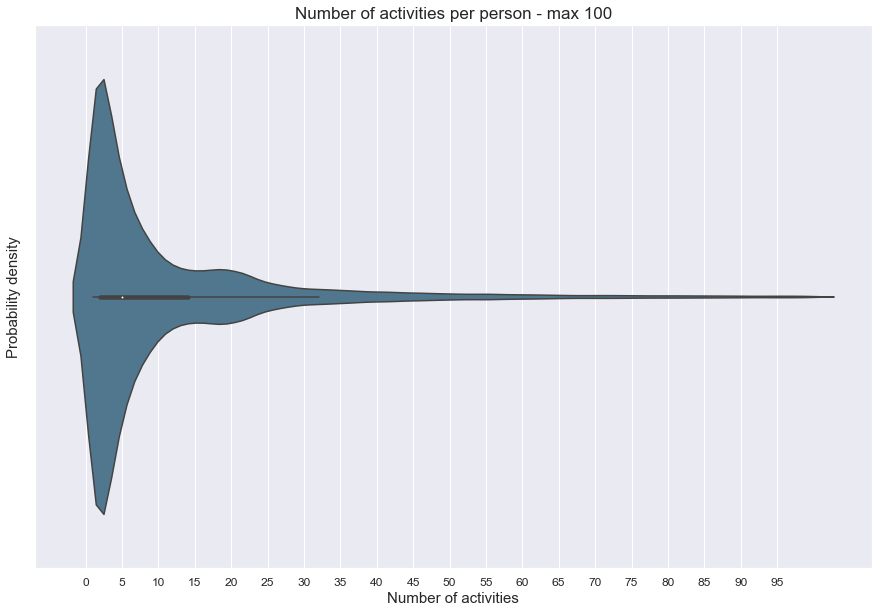

In [128]:
sns.violinplot(peps_acts['activity_index'][peps_acts['activity_index']<=100], color = '#477998')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.xticks(ticks = list(range(0,100,5)))
plt.title('Number of activities per person - max 100')

There is a number of outliers in case of the number of activities per person. The **median oscillates around 5** activities per person, but there are people with **40.000 activities** and more.

**Number of activities depending on the outcome**

In [140]:
peps_acts_0 = pd.DataFrame(train_data[train_data['outcome']==0].groupby(by = 'people_id')['activity_index'].count().reset_index())
peps_acts_1 = pd.DataFrame(train_data[train_data['outcome']==1].groupby(by = 'people_id')['activity_index'].count().reset_index())

Text(0.5, 1.0, 'Number of activities with negative outcome per person')

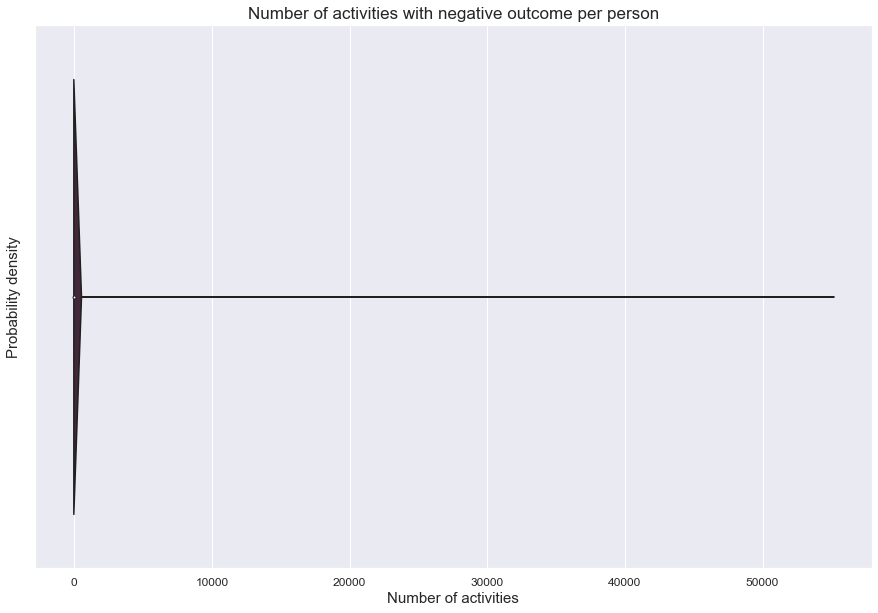

In [141]:
sns.violinplot(peps_acts_0['activity_index'], color = '#48233C')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.title('Number of activities with negative outcome per person')

Text(0.5, 1.0, 'Number of activities with negative outcome per person - max 100')

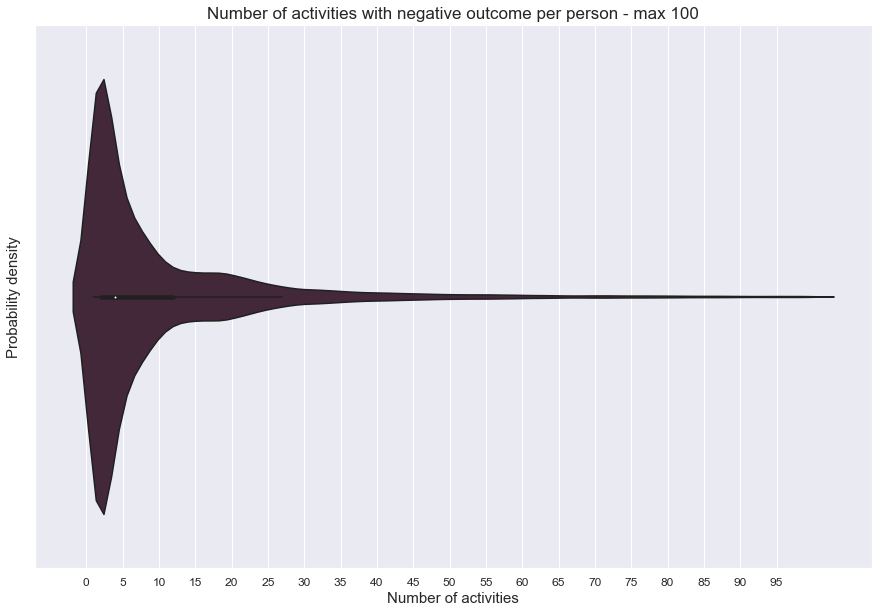

In [150]:
sns.violinplot(peps_acts_0['activity_index'][peps_acts_0['activity_index']<=100], color = '#48233C')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.xticks(ticks = list(range(0,100,5)))
plt.title('Number of activities with negative outcome per person - max 100')

The shape of the distribution for activities with negative outcomes is similar to that of all activities. The median, however, is slightly smaller - **around 4**. The **1.5x interquantile range is smaller** than for all activities.

Text(0.5, 1.0, 'Number of activities with positive outcome per person')

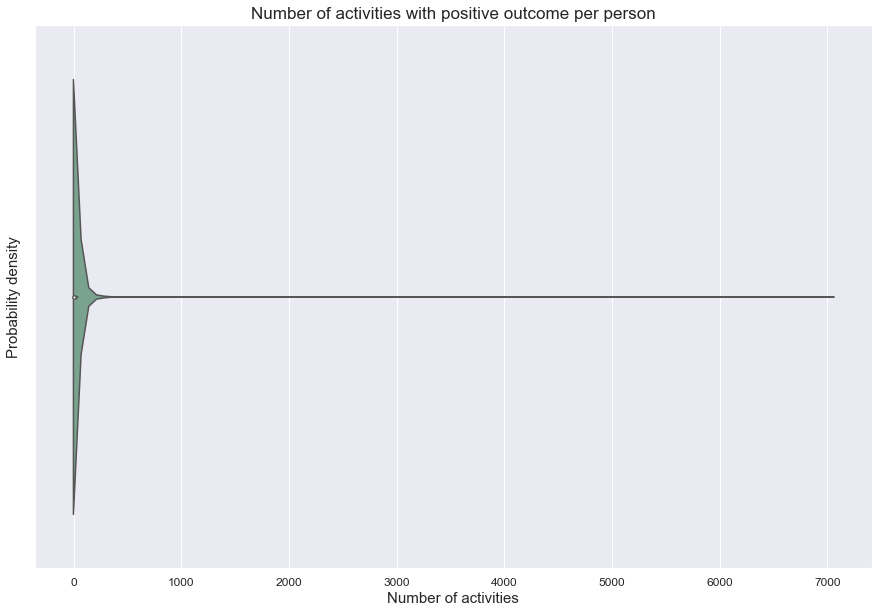

In [142]:
sns.violinplot(peps_acts_1['activity_index'], color = '#72A98F')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.title('Number of activities with positive outcome per person')

Text(0.5, 1.0, 'Number of activities with positive outcome per person - max 100')

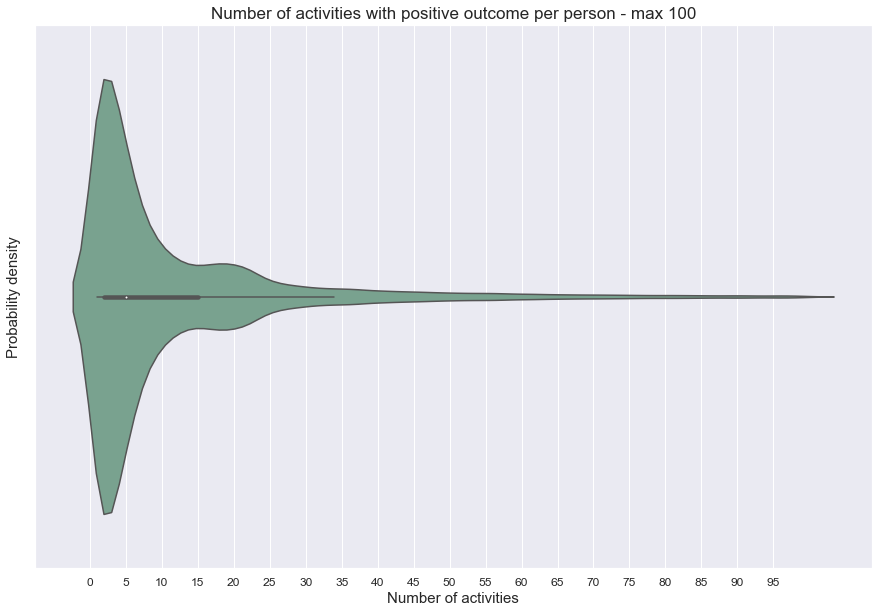

In [147]:
sns.violinplot(peps_acts_1['activity_index'][peps_acts_1['activity_index']<=100], color = '#72A98F')
plt.xlabel('Number of activities')
plt.ylabel('Probability density')
plt.xticks(ticks = list(range(0,100,5)))
plt.title('Number of activities with positive outcome per person - max 100')

The shape of the distribution for activities with positive outcomes shows some differences comparing to the previous plots. The **median oscillates around 5**, just as in case of all activities. 

However, there is a noticably higher density **between 15 and 25** activities, which can not be seen in previous plots.

In [ ]:
# train_data.set_index('activity_index')

In [ ]:
# train_data.drop(columns=['char_10_act','group_1'], axis=1, inplace=True)

As stated above, `char_10` and `group_1` are deleted due to a high number of categories

In [ ]:
# full = pd.concat([train_data, test_data])

In [ ]:
# pd.DataFrame(full['activity_id'].value_counts().reset_index()).sort_values(by='activity_id', ascending=False).head(20)

### Model preparation